<a href="https://colab.research.google.com/github/Innocente0/summative_MLOP/blob/main/summative_MLOP_Aline_Innocente.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Animals ML Pipeline**

In [1]:
from google.colab import files
uploaded = files.upload()

Saving animal_datasets.zip to animal_datasets.zip


In [15]:
!mkdir -p data/raw/animal_data
!pwd
!ls
!unzip -o animal_datasets.zip -d data/raw/animal_data


/content
animal_datasets.zip  data  sample_data
Archive:  animal_datasets.zip
  inflating: data/raw/animal_data/animal_data/Bear/Bear_10.jpg  
  inflating: data/raw/animal_data/animal_data/Bear/Bear_10_1.jpg  
  inflating: data/raw/animal_data/animal_data/Bear/Bear_10_2.jpg  
  inflating: data/raw/animal_data/animal_data/Bear/Bear_10_3.jpg  
  inflating: data/raw/animal_data/animal_data/Bear/Bear_11.jpeg  
  inflating: data/raw/animal_data/animal_data/Bear/Bear_11_1.jpg  
  inflating: data/raw/animal_data/animal_data/Bear/Bear_11_2.jpg  
  inflating: data/raw/animal_data/animal_data/Bear/Bear_11_3.jpg  
  inflating: data/raw/animal_data/animal_data/Bear/Bear_12.jpeg  
  inflating: data/raw/animal_data/animal_data/Bear/Bear_12_1.jpg  
  inflating: data/raw/animal_data/animal_data/Bear/Bear_12_2.jpg  
  inflating: data/raw/animal_data/animal_data/Bear/Bear_12_3.jpg  
  inflating: data/raw/animal_data/animal_data/Bear/Bear_13.jpeg  
  inflating: data/raw/animal_data/animal_data/Bear/Bear_

In [16]:
import os, shutil, random

RAW_ROOT = "data/raw/animal_data"
TRAIN_DIR = "data/train"
TEST_DIR = "data/test"

candidates = [d for d in os.listdir(RAW_ROOT) if os.path.isdir(os.path.join(RAW_ROOT, d))]

if len(candidates) == 1:
    CLASSES_ROOT = os.path.join(RAW_ROOT, candidates[0])
else:
    CLASSES_ROOT = RAW_ROOT

print("Using classes root:", CLASSES_ROOT)

if os.path.exists(TRAIN_DIR):
    shutil.rmtree(TRAIN_DIR)
if os.path.exists(TEST_DIR):
    shutil.rmtree(TEST_DIR)

os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)

# splitting image from their classes
for cls in os.listdir(CLASSES_ROOT):
    cls_path = os.path.join(CLASSES_ROOT, cls)
    if not os.path.isdir(cls_path):
        continue

    images = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
    if len(images) == 0:
        continue

    random.shuffle(images)

    split_idx = int(0.8 * len(images))
    train_imgs = images[:split_idx]
    test_imgs  = images[split_idx:]

    train_cls_dir = os.path.join(TRAIN_DIR, cls)
    test_cls_dir  = os.path.join(TEST_DIR, cls)
    os.makedirs(train_cls_dir, exist_ok=True)
    os.makedirs(test_cls_dir, exist_ok=True)

    for fname in train_imgs:
        shutil.copy2(os.path.join(cls_path, fname),
                     os.path.join(train_cls_dir, fname))

    for fname in test_imgs:
        shutil.copy2(os.path.join(cls_path, fname),
                     os.path.join(test_cls_dir, fname))

print("Done splitting into:")
print("  -", TRAIN_DIR)
print("  -", TEST_DIR)

Using classes root: data/raw/animal_data/animal_data
Done splitting into:
  - data/train
  - data/test


**In this cell I imported Python libraries needed for the rest of the notebook**

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


**Define data paths and parameters**

I define the paths to my training and testing folders, which were created earlier after splitting the dataset. I also set:

img_height and img_width to 128 * 128 (they were 224 * 224), which is the size each image will be resized to.

batch_size to 32, which controls how many images are processed at once during training.

In [20]:
train_dir = "data/train"
test_dir = "data/test"

img_height, img_width = 128, 128
batch_size = 32

**Data preprocessing and generators**

This cell builds three image generators for training, validation, and testing.

Training data is rescaled to [0,1] and augmented (rotations, shifts, zoom, flips), with 20% reserved as validation, while test data is only rescaled.

It also computes num_classes (number of animal categories) and class_indices (mapping from class names to integer labels).

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% of training data will be used as validation
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_classes = train_gen.num_classes
class_indices = train_gen.class_indices
num_classes, class_indices

Found 1247 images belonging to 15 classes.
Found 302 images belonging to 15 classes.
Found 395 images belonging to 15 classes.


(15,
 {'Bear': 0,
  'Bird': 1,
  'Cat': 2,
  'Cow': 3,
  'Deer': 4,
  'Dog': 5,
  'Dolphin': 6,
  'Elephant': 7,
  'Giraffe': 8,
  'Horse': 9,
  'Kangaroo': 10,
  'Lion': 11,
  'Panda': 12,
  'Tiger': 13,
  'Zebra': 14})

**Visualizing sample images**

Plotted 9 image examples. Each image shows the rescaling and augmentation.

This visualization helps me confirm that the data or images are loaded correctly.

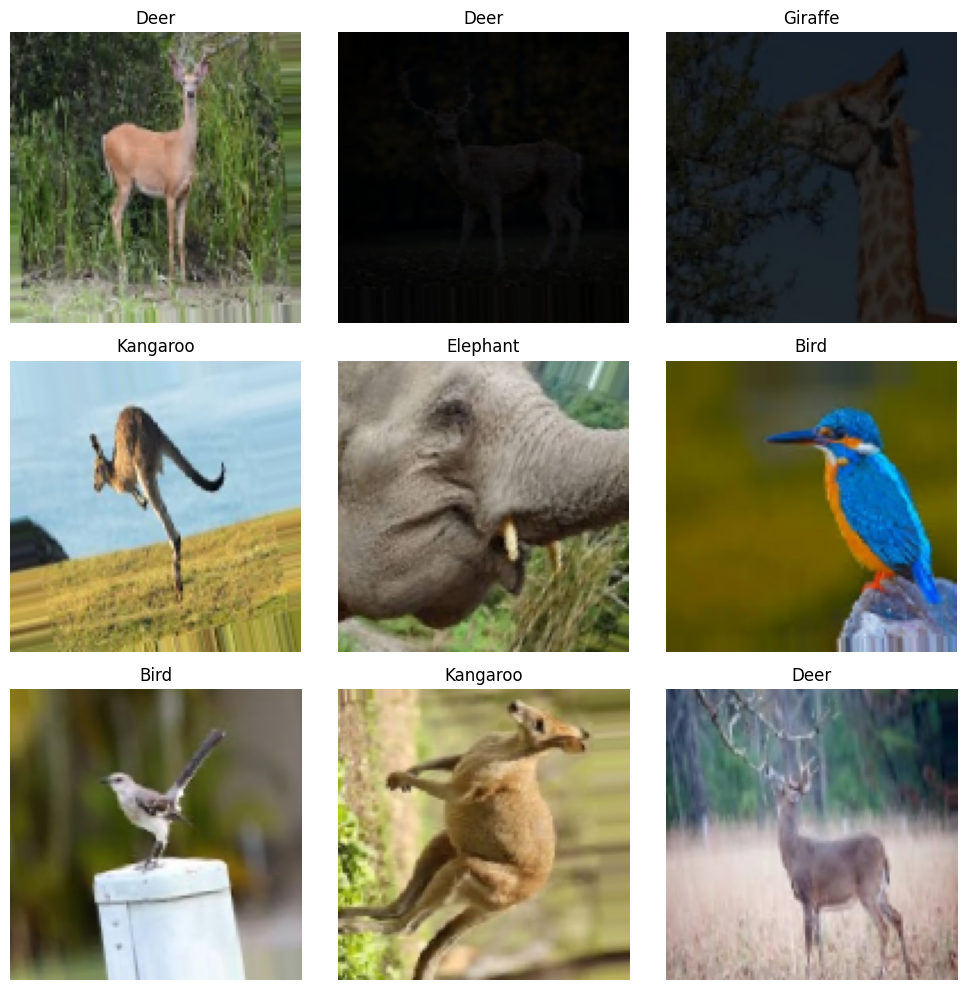

In [22]:
import itertools

images, labels = next(train_gen)
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])

    class_name = list(class_indices.keys())[list(class_indices.values()).index(label_idx)]
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

**Build and compile the CNN model**

I define a CNN with multiple Conv2D + MaxPooling2D layers to extract visual features and a final softmax layer to output class probabilities.

To reduce overfitting, I use L2 regularization and a Dropout layer (0.5) before the final output.

I optimize the model with the Adam optimizer (lr=1e-3), use categorical crossentropy loss for multi-class classification, and monitor accuracy while model.summary() shows the architecture.

In [23]:
# Build the CNN model with regularization and dropout
l2_reg = 1e-4
learning_rate = 1e-3

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(l2_reg),
           input_shape=(img_height, img_width, 3)),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(l2_reg)),
    MaxPooling2D(),

    Conv2D(128, (3,3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(l2_reg)),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=learning_rate)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,485,967 (32.37 MB)

 Trainable params: 8,485,967 (32.37 MB)

 Non-trainable params: 0 (0.00 B)

**Model training with optimization techniques**

This cell trains the CNN and saves it in a models folder.

It uses EarlyStopping (monitoring val_loss, patience=5, restore best weights) and ModelCheckpoint to always keep the best version at models/base_animal_cnn.h5.

Training runs on train_gen and val_gen for up to 30 epochs, and the history object records loss and accuracy over time for plotting later.

In [24]:
# Train the model using early stopping and model checkpointing

os.makedirs("models", exist_ok=True)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

checkpoint_path = "models/base_animal_cnn.h5"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    save_best_only=True
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0992 - loss: 2.8100

39/39 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.0997 - loss: 2.8083 - val_accuracy: 0.1656 - val_loss: 2.5677
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1582 - loss: 2.6125

39/39 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.1587 - loss: 2.6111 - val_accuracy: 0.2285 - val_loss: 2.4620
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.2265 - loss: 2.4287 - val_accuracy: 0.2517 - val_loss: 2.4789
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2358 - loss: 2.3001

39/39 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.2365 - loss: 2.2997 - val_accuracy: 0.3146 - val_loss: 2.2366
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.3203 - loss: 2.1451 - val_accuracy: 0.3311 - val_loss: 2.2406
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3533 - loss: 2.0846

39/39 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.3532 - loss: 2.0839 - val_accuracy: 0.3609 - val_loss: 2.1752
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3527 - loss: 2.0096

39/39 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.3532 - loss: 2.0083 - val_accuracy: 0.3377 - val_loss: 2.1677
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4263 - loss: 1.8860

39/39 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.4264 - loss: 1.8858 - val_accuracy: 0.3576 - val_loss: 2.0971
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4212 - loss: 1.8794 - val_accuracy: 0.3377 - val_loss: 2.1470
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5132 - loss: 1.6404

39/39 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5128 - loss: 1.6416 - val_accuracy: 0.3974 - val_loss: 1.9838
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.4537 - loss: 1.6923 - val_accuracy: 0.3940 - val_loss: 2.0142
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.5411 - loss: 1.5410 - val_accuracy: 0.3940 - val_loss: 2.1189
Epoch 13/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.5172 - loss: 1.5289 - val_accuracy: 0.4272 - val_loss: 2.0657
Epoch 14/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.5302 - loss: 1.5923 - val_accuracy: 0.3907 - val_loss: 1.9945
Epoch 15/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5415 - loss: 1.5354 - val_accuracy: 0.4040 - val_loss: 2.2165


**Training and validation curves**

This cell plots training vs. validation accuracy and loss over epochs.

It helps visualize how well the model is learning and generalizing.

I use these curves to check for overfitting and to see where early stopping kicked in.

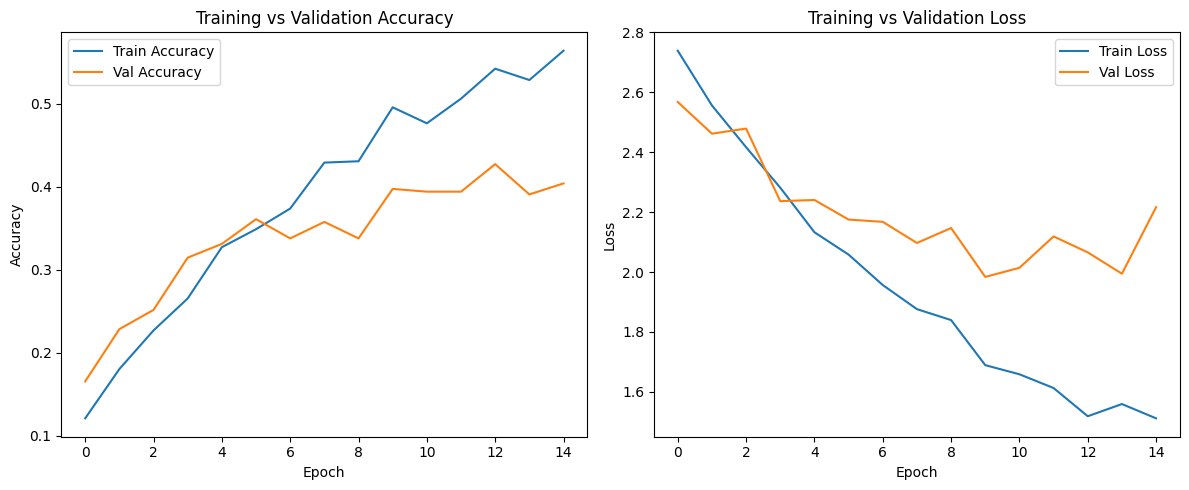

In [25]:
# Plot training and validation curves for loss and accuracy

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

**Model evaluation with multiple metrics**

In this cell I evaluate the model on the test set using model.evaluate(test_gen) to obtain test loss and accuracy.

Then I generate predictions for all test images and, using scikit-learn, compute accuracy, F1-score, precision, and recall plus a detailed classification report per class.

This satisfies the rubric requirement of using at least four evaluation metrics: loss, accuracy, F1, precision, and recall.

In [26]:
# Evaluate the model on the test set with multiple metrics

# Keras gives test loss and test accuracy
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss (Keras):", test_loss)
print("Test Accuracy (Keras):", test_acc)

# Get predictions and true labels
y_true = test_gen.classes
y_prob = model.predict(test_gen)
y_pred = np.argmax(y_prob, axis=1)

# Compute sklearn metrics
acc  = accuracy_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred, average="weighted")
prec = precision_score(y_true, y_pred, average="weighted")
rec  = recall_score(y_true, y_pred, average="weighted")

print("\nEvaluation Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")

# Detailed classification report
target_names = list(test_gen.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 643ms/step - accuracy: 0.4008 - loss: 2.2261
Test Loss (Keras): 1.9855341911315918
Test Accuracy (Keras): 0.4683544337749481
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 320ms/step

Evaluation Metrics:
Accuracy:  0.4684
F1 Score:  0.4469
Precision: 0.4900
Recall:    0.4684

Classification Report:
              precision    recall  f1-score   support

        Bear       0.41      0.28      0.33        25
        Bird       0.58      0.50      0.54        28
         Cat       0.38      0.24      0.29        25
         Cow       0.37      0.48      0.42        27
        Deer       0.20      0.19      0.20        26
         Dog       0.44      0.28      0.34        25
     Dolphin       0.80      0.92      0.86        26
    Elephant       0.60      0.56      0.58        27
     Giraffe       0.40      0.54      0.46        26
       Horse       0.56      0.19      0.29        26
    Kangaroo       0.57      0.15      0.24        26
        Lion       0.62      0.30     

**Confusion matrix**

This cell plots the confusion matrix for the model’s predictions on the test set.

High values on the diagonal indicate correct predictions, while off-diagonal values show misclassifications.

It helps reveal which animal classes the model confuses and which ones are harder to classify.

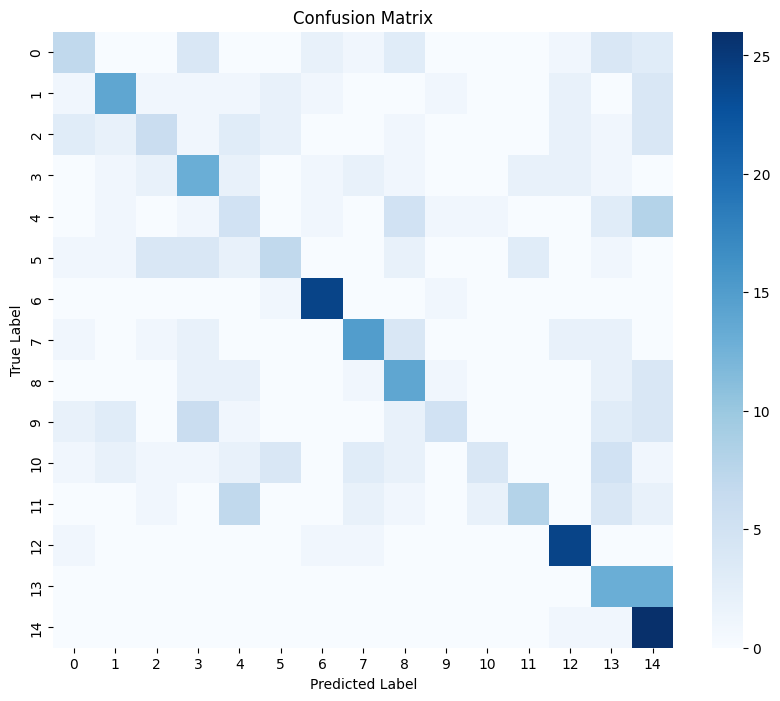

In [27]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Save the trained model (custom pre-trained model)**

I save the trained CNN as models/base_animal_cnn.h5, which becomes my custom pre-trained model.

Later I will load this file in the FastAPI backend for prediction and as the starting point for retraining, satisfying the “pre-trained model” requirement.

In [29]:
save_path = "models/base_animal_cnn.h5"
model.save(save_path)
print(f"Model saved to {save_path}")

Model saved to models/base_animal_cnn.h5
